In [2]:
import torch
import torch.optim as optim
import numpy as np
from flows_utils import *
from training_utils import *
from plot_utils import *
from sampling_utils import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

In [3]:
class Complex_Constraints:
    def __init__(self):
        """
        xTx <= 0
        """
        self.A = torch.tensor(np.array([[1., -1.], [-1., -1.], [1., 1.], [-1., 1.]])).permute(1, 0).to(device=device)
        # self.bias = 2
        # self.b = torch.tensor(np.array([self.bias] * 4)).view(1, 4).to(device=device)
        # self.t_test = [ [1.5, 1.5, 0.5, 1.5, 1.5, 0.5],
        #                 [1.5, 0.5, 1.5, 1.5, 0.5, 0.5],
        #                 [0.5, 1.5, 0.5, 0.5, 1.5, 0.5],
        #                 [0.5, 0.5, 1.5, 1.5, 1.5, 0.5]]
        self.sampling_range = [0.1, 2]
        self.t_dim = 6 + 2
        self.n_case = 8
        self.t_test = np.random.uniform(low=self.sampling_range[0],
                                        high=self.sampling_range[1],
                                        size=[self.n_case,self.t_dim])

    def cal_penalty(self, t, x):
        """
        y <= 0.5*x^2 + [0,2]
        y >= -0.5x^2 - [0,2]
        """
        bias = t[:,2:6]
        violation = torch.matmul(x, self.A) - (bias)
        violation_1 = (-t[:,[6]] * (x[:, [0]]) ** 2 + x[:, [1]] - t[:, [0]])
        violation_2 = (-t[:,[7]] * (x[:, [0]]) ** 2 - x[:, [1]] - t[:, [1]])
        violation = torch.cat([violation, violation_1, violation_2], dim=-1)
        return torch.clamp(violation, 0)

    def check_feasibility(self, t, x):
        return self.cal_penalty(t, x)

    def scale(self, t, x):
        return x

    def complete_partial(self, t, x, backward=True):
        return x

    def plot_boundary(self, t):
        x = np.linspace(-5, 5, 1000)
        plt.plot(x,  x - t[2], linewidth=1.5, alpha=0.7, c='cornflowerblue')
        plt.plot(x, -x - t[3], linewidth=1.5, alpha=0.7, c='cornflowerblue')
        plt.plot(x, -x + t[4], linewidth=1.5, alpha=0.7, c='cornflowerblue')
        plt.plot(x,  x + t[5], linewidth=1.5, alpha=0.7, c='cornflowerblue')
        plt.plot(x, t[6] * x ** 2 + t[0], linewidth=1.5, alpha=0.7, c='cornflowerblue')
        plt.plot(x, -t[7] * x ** 2 - t[1], linewidth=1.5, alpha=0.7, c='cornflowerblue')

In [9]:

def constraint_learning(paras):
    simple_set = paras['init_shape']
    constraints = paras['constraint']
    distortion = paras['distortion_coefficient']
    instance_file = f'models/toy_example_{simple_set}_{constraints.__class__.__name__}/distortion_{distortion}'

    #### Input-Output Specification: (t->x)
    n_dim = 2
    t_dim = constraints.t_dim
    #### Flow-based model: sphere -> constraint set
    num_layer = paras['num_layer']
    modules = []
    for l in range(num_layer):
        modules += [ActNorm(num_inputs=n_dim),
                    LUInvertibleMM(num_inputs=n_dim),
                    ActNorm(num_inputs=n_dim),
                    MADE(num_inputs=n_dim, num_hidden=32, num_cond_inputs=t_dim)]
    modules.append(ActNorm(num_inputs=n_dim))
    model = INN(modules).to(device=device)
    if not os.path.exists(instance_file):
        os.mkdir(instance_file)

    #### Sampling input parameters and output decision
    n_samples = paras['n_samples']
    t_samples = paras['t_samples']
    x_train = sampling_body(n_samples, n_dim, simple_set)  # + bias
    t_train = np.random.uniform(low=constraints.sampling_range[0], high=constraints.sampling_range[1],
                                size=[t_samples, t_dim])
    x_train_tensor = torch.tensor(x_train).view(-1, n_dim).to(device=device)
    t_train_tensor = torch.tensor(t_train).view(-1, t_dim).to(device=device)
    optimizer = optim.Adam(model.parameters(), lr=paras['lr'], weight_decay=1e-6)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=paras['lr_decay_step'], gamma=paras['lr_decay'])
    #### Unsupervised Training for Hemo Mapping
    model, volume_list, penalty_list, dist_list, trans_list = training(model, constraints, optimizer, scheduler,
                                                                       x_train_tensor, t_train_tensor, paras)
    torch.save(model, instance_file + '/model.pth')
    np.save(instance_file + '/records.npy', [volume_list, penalty_list, dist_list, trans_list])

In [10]:
paras = {'init_shape': 'sphere',
             'seed': 2002,
             'constraint': Complex_Constraints(),
             'bound': [-1,1],
             'scale_ratio': 1.,
             'n_samples': 1024,
             't_samples': 10000,
             'total_iteration': 10000,
             'batch_size': 256,
             'num_layer': 3,
             'lr': 1e-3,
             'lr_decay': 0.9,
             'lr_decay_step': 1000,
             'penalty_coefficient': 10,
             'distortion_coefficient': 0.1,
             'transport_coefficient': 0.0,}
constraint_learning(paras)

Iteration: 1000/10000, Volume: -0.3139, Penalty: 0.0110, Distortion: 0.2158, Transport: 0.5106, test: 0.00027348
Iteration: 2000/10000, Volume: -0.2765, Penalty: 0.0096, Distortion: 0.1779, Transport: 0.5554, test: 0.00000000
Iteration: 3000/10000, Volume: -0.2966, Penalty: 0.0079, Distortion: 0.1470, Transport: 0.5496, test: 0.00000000
Iteration: 4000/10000, Volume: -0.2568, Penalty: 0.0084, Distortion: 0.1521, Transport: 0.5901, test: 0.00000000
Iteration: 5000/10000, Volume: -0.2587, Penalty: 0.0047, Distortion: 0.1525, Transport: 0.6163, test: 0.00000000
Iteration: 6000/10000, Volume: -0.2699, Penalty: 0.0071, Distortion: 0.1523, Transport: 0.5753, test: 0.00000000
Iteration: 7000/10000, Volume: -0.2777, Penalty: 0.0111, Distortion: 0.1566, Transport: 0.5344, test: 0.00000000
Iteration: 8000/10000, Volume: -0.2594, Penalty: 0.0075, Distortion: 0.1579, Transport: 0.5724, test: 0.00000000
Iteration: 9000/10000, Volume: -0.2583, Penalty: 0.0052, Distortion: 0.1490, Transport: 0.5760, 

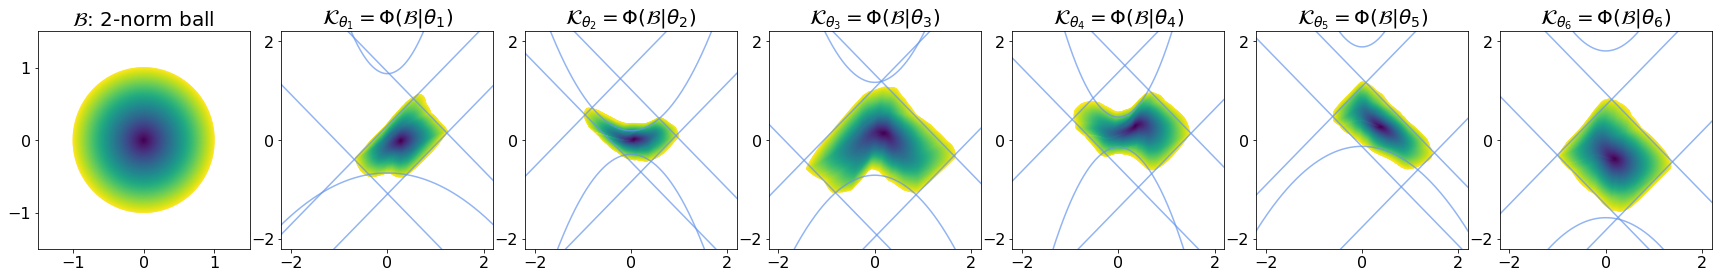

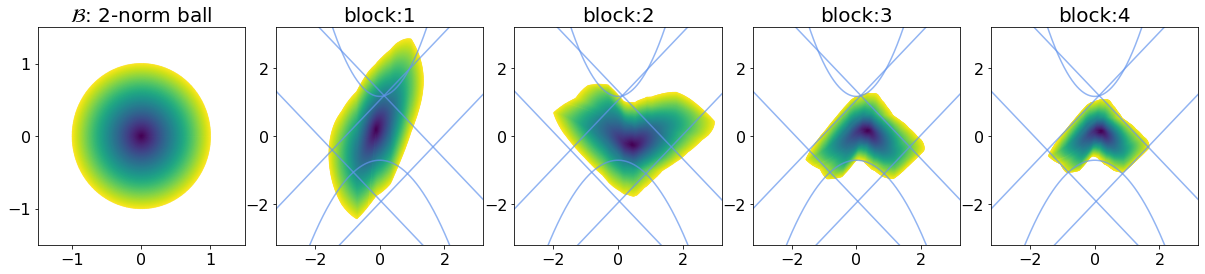

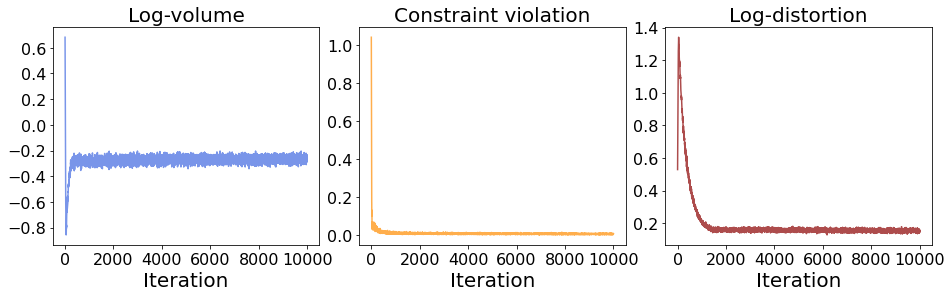

In [11]:
#### Ploting results
simple_set = paras['init_shape']
constraints = paras['constraint']
distortion = paras['distortion_coefficient']
instance_file = f'models/toy_example_{simple_set}_{constraints.__class__.__name__}/distortion_{distortion}'
n_dim = 2
x_train = sampling_body(100000, n_dim, simple_set)
x_train_tensor = torch.tensor(x_train).view(-1, n_dim).to(device=device)
model = torch.load(instance_file + '/model.pth')
volume_list, penalty_list, dist_list, trans_list = np.load(instance_file + '/records.npy')
np.random.seed(paras['seed'])
constraints.t_test = np.random.uniform(low=constraints.sampling_range[0],
                                        high=constraints.sampling_range[1],
                                        size=[6, constraints.t_dim])
scatter_constraint_approximation(model, constraints, x_train_tensor, simple_set, instance_file, paras)
scatter_constraint_evolution(model, constraints, x_train_tensor, simple_set, instance_file, paras)
plot_convergence(volume_list, penalty_list, dist_list, trans_list, instance_file)